<a href="https://colab.research.google.com/github/sachaRfd/Reef_Project/blob/main/basic_Reef_Run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Very Basic Test run: 
- Had to import
  - 10 .npy files containing 10 reefs --> Of size 20 20 for testing --> model was running but not learning anything obviously


# Comments: 
- When trying with the actuall image sizes --> which are [5490, 4123] --> size of the .npy files were massive.
- Even when i loaded some of these --> Program would run out RAM even with 1 batch-size



# Code below was run with images of size 20 by 20 so no real conclusion to be made.



In [1]:
! pip install tensorflow
! pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Using Robust AutoEncoder:

In [2]:
from Dataset import reef_dataset
import rasterio
import tensorflow as tf
import numpy.linalg as nplin
import numpy as np
import tensorflow.compat.v1 as tf
import time
tf.disable_v2_behavior()


def batches(l, n):
    """Yield successive n-sized batches from l, the last batch is the left indexes."""
    for i in range(0, l, n):
        yield range(i, min(l, i+n))


class Deep_Autoencoder(object):
    def __init__(self, sess, input_dim_list=[784, 400]):
        """input_dim_list must include the original data dimension"""
        assert len(input_dim_list) >= 2
        self.W_list = []
        self.encoding_b_list = []
        self.decoding_b_list = []
        self.dim_list = input_dim_list
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=())
        # Encoders parameters
        for i in range(len(input_dim_list)-1):
            init_max_value = np.sqrt(
                6. / (self.dim_list[i] + self.dim_list[i+1]))
            self.W_list.append(tf.Variable(tf.random.uniform([self.dim_list[i], self.dim_list[i+1]],
                                                             np.negative(init_max_value), init_max_value)))
            self.encoding_b_list.append(tf.Variable(
                tf.random.uniform([self.dim_list[i+1]], -0.1, 0.1)))
        # Decoders parameters
        for i in range(len(input_dim_list)-2, -1, -1):
            self.decoding_b_list.append(tf.Variable(
                tf.random.uniform([self.dim_list[i]], -0.1, 0.1)))
        # Placeholder for input
        self.input_x = tf.compat.v1.placeholder(
            tf.float32, [None, self.dim_list[0]])
        # coding graph :
        last_layer = self.input_x
        for weight, bias in zip(self.W_list, self.encoding_b_list):
            hidden = tf.sigmoid(tf.matmul(last_layer, weight) + bias)
            last_layer = hidden
        self.hidden = hidden
        # decode graph:
        for weight, bias in zip(reversed(self.W_list), self.decoding_b_list):
            hidden = tf.sigmoid(
                tf.matmul(last_layer, tf.transpose(weight)) + bias)
            last_layer = hidden
        self.recon = last_layer

        self.cost = 200 * tf.reduce_mean(tf.square(self.input_x - self.recon))
#         self.cost = 200*tf.losses.log_loss(self.recon, self.input_x)
        self.train_step = tf.compat.v1.train.AdamOptimizer(
            self.learning_rate).minimize(self.cost)
        sess.run(tf.compat.v1.global_variables_initializer())

    def fit(self, X, sess, learning_rate=0.15,
            iteration=200, batch_size=50, init=False, verbose=False):
        assert X.shape[1] == self.dim_list[0]
        if init:
            sess.run(tf.global_variables_initializer())
        sample_size = X.shape[0]
        for i in range(iteration):
            for one_batch in batches(sample_size, batch_size):
                sess.run(self.train_step, feed_dict={
                         self.input_x: X[one_batch], self.learning_rate: learning_rate})  # noqa

            if verbose and i % 20 == 0:
                e = self.cost.eval(session=sess, feed_dict={self.input_x: X})
                print("    iteration : ", i, ", cost : ", e)

    def transform(self, X, sess):
        return self.hidden

    def getRecon(self, X, sess):
        return self.recon.eval(session=sess, feed_dict={self.input_x: X})

##################### test a machine with different data size#####################


def test():
    start_time = time.time()
    with tf.Session() as sess:
        ae = Deep_Autoencoder(sess=sess, input_dim_list=[
                              784, 625, 400, 225, 100])
        error = ae.fit(x[:1000], sess=sess, learning_rate=0.01,
                       batch_size=500, iteration=1000, verbose=False)

    print("size 1000 Runing time:" + str(time.time() - start_time) + " s")

    start_time = time.time()
    with tf.Session() as sess:
        ae = Deep_Autoencoder(sess=sess, input_dim_list=[
                              784, 625, 400, 225, 100])
        error = ae.fit(x[:10000], sess=sess, learning_rate=0.01,
                       batch_size=500, iteration=1000, verbose=False)

    print("size 10,000 Runing time:" + str(time.time() - start_time) + " s")

    start_time = time.time()
    with tf.Session() as sess:
        ae = Deep_Autoencoder(sess=sess, input_dim_list=[
                              784, 625, 400, 225, 100])
        error = ae.fit(x[:20000], sess=sess, learning_rate=0.01,
                       batch_size=500, iteration=1000, verbose=False)

    print("size 20,000 Runing time:" + str(time.time() - start_time) + " s")

    start_time = time.time()
    with tf.Session() as sess:
        ae = Deep_Autoencoder(sess=sess, input_dim_list=[
                              784, 625, 400, 225, 100])
        error = ae.fit(x[:50000], sess=sess, learning_rate=0.01,
                       batch_size=500, iteration=1000, verbose=False)

    print("size 50,000 Runing time:" + str(time.time() - start_time) + " s")


def shrink(epsilon, x):
    """
    @Original Author: Prof. Randy
    @Modified by: Chong Zhou
    update to python3: 03/15/2019
    Args:
        epsilon: the shrinkage parameter (either a scalar or a vector)
        x: the vector to shrink on

    Returns:
        The shrunk vector
    """
    output = np.array(x*0.)

    for idx, ele in enumerate(x):
        if ele > epsilon:
            output[idx] = ele - epsilon
        elif ele < -epsilon:
            output[idx] = ele + epsilon
        else:
            output[idx] = 0.
    return output


class RDAE(object):
    """
    @author: Chong Zhou
    2.0 version.
    complete: 10/17/2016
    version changes: move implementation from theano to tensorflow.
    3.0
    complete: 2/12/2018
    changes: delete unused parameter, move shrink function to other file
    update: 03/15/2019
        update to python3 
    Des:
        X = L + S
        L is a non-linearly low rank matrix and S is a sparse matrix.
        argmin ||L - Decoder(Encoder(L))|| + ||S||_1
        Use Alternating projection to train model
    """

    def __init__(self, sess, layers_sizes, lambda_=1.0, error=1.0e-7):
        """
        sess: a Tensorflow tf.Session object
        layers_sizes: a list that contain the deep ae layer sizes, including the input layer  # noqa
        lambda_: tuning the weight of l1 penalty of S
        error: converge criterior for jump out training iteration
        """
        self.lambda_ = lambda_
        self.layers_sizes = layers_sizes
        self.error = error
        self.errors = []
        self.AE = Deep_Autoencoder(
            sess=sess, input_dim_list=self.layers_sizes)

    def fit(self, X, sess, learning_rate=0.15, inner_iteration=50,
            iteration=20, batch_size=50, verbose=False):
        # The first layer must be the input layer, so they should have same sizes.  # noqa
        assert X.shape[1] == self.layers_sizes[0]

        # initialize L, S, mu(shrinkage operator)
        self.L = np.zeros(X.shape)
        self.S = np.zeros(X.shape)

        mu = (X.size) / (4.0 * nplin.norm(X, 1))
        print("shrink parameter:", self.lambda_ / mu)
        LS0 = self.L + self.S

        XFnorm = nplin.norm(X, 'fro')
        if verbose:
            print("X shape: ", X.shape)
            print("L shape: ", self.L.shape)
            print("S shape: ", self.S.shape)
            print("mu: ", mu)
            print("XFnorm: ", XFnorm)

        for it in range(iteration):
            if verbose:
                print("Out iteration: ", it)
            # alternating project, first project to L
            self.L = X - self.S
            # Using L to train the auto-encoder
            self.AE.fit(X=self.L, sess=sess,
                        iteration=inner_iteration,
                        learning_rate=learning_rate,
                        batch_size=batch_size,
                        verbose=verbose)
            # get optmized L
            self.L = self.AE.getRecon(X=self.L, sess=sess)
            # alternating project, now project to S
            self.S = shrink(
                self.lambda_/mu, (X - self.L).reshape(X.size)).reshape(X.shape)

            # break criterion 1: the L and S are close enough to X
            c1 = nplin.norm(X - self.L - self.S, 'fro') / XFnorm
            # break criterion 2: there is no changes for L and S
            c2 = np.min([mu, np.sqrt(mu)]) * \
                nplin.norm(LS0 - self.L - self.S) / XFnorm

            if verbose:
                print("c1: ", c1)
                print("c2: ", c2)

            if c1 < self.error and c2 < self.error:
                print("early break")
                break
            # save L + S for c2 check in the next iteration
            LS0 = self.L + self.S

        return self.L, self.S

    def transform(self, X, sess):
        L = X - self.S
        return self.AE.transform(X=L, sess=sess)

    def getRecon(self, X, sess):
        return self.AE.getRecon(X, sess=sess)


Instructions for updating:
non-resource variables are not supported in the long term


[[  0   0   0 ...   0   0   0]
 [  0   0 145 ...   0   0   0]
 [  0   0 218 ...   0   0   0]
 ...
 [  0 164 251 ...   0   0   0]
 [  0 131 211 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
(200, 200)


(10, 40000)

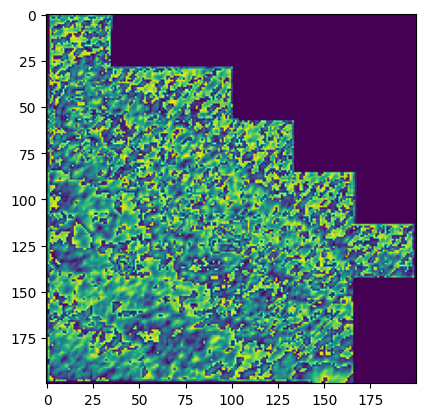

In [3]:
import matplotlib.pyplot as plt


test = np.load("/content/other_reef/Reef_0.npy", allow_pickle=True)
print(test)
print(test.shape)


list_test = []
for i in range(10):
  test_arr = np.load(f"/content/other_reef/Reef_{i}.npy", allow_pickle=True)
  list_test.append(test_arr)

list_test = np.array(list_test)
plt.imshow(list_test[0])

list_test = list_test.reshape(10, 200*200)
list_test.shape

In [8]:
import tensorflow as tf

with tf.compat.v1.Session() as sess:
    rae = RDAE(sess=sess, lambda_=2000, layers_sizes=[200*200, 10000, 500, 400, 100])
    L, S = rae.fit(list_test, sess=sess, learning_rate=0.01, batch_size=1, inner_iteration=50,
                   iteration=5, verbose=True)
    recon_rae = rae.getRecon(list_test, sess=sess)

shrink parameter: 45.26
X shape:  (10, 40000)
L shape:  (10, 40000)
S shape:  (10, 40000)
mu:  44.18912947414936
XFnorm:  86981.60374469995
Out iteration:  0
    iteration :  0 , cost :  3749964.5
    iteration :  20 , cost :  3749964.5
    iteration :  40 , cost :  3749964.5
c1:  0.2891602587680221
c2:  4.96842850482677
Out iteration:  1
    iteration :  0 , cost :  316308.97
    iteration :  20 , cost :  316308.97
    iteration :  40 , cost :  316308.97
c1:  0.2891602587680221
c2:  2.093718119164435e-08
Out iteration:  2
    iteration :  0 , cost :  316308.97
    iteration :  20 , cost :  316308.97
    iteration :  40 , cost :  316308.97
c1:  0.2891602587680221
c2:  2.093718119164435e-08
Out iteration:  3
    iteration :  0 , cost :  316308.97
    iteration :  20 , cost :  316308.97
    iteration :  40 , cost :  316308.97
c1:  0.2891602587680221
c2:  2.093718119164435e-08
Out iteration:  4
    iteration :  0 , cost :  316308.97
    iteration :  20 , cost :  316308.97
    iteration : 

This is the 0 th image:
Original


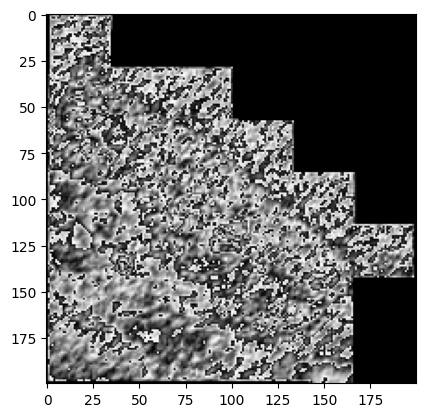

Reconstructed:


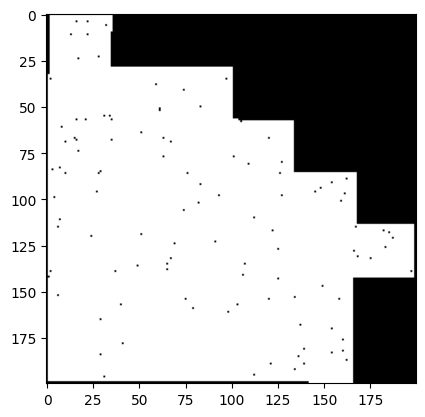

In [9]:
import matplotlib.pyplot as plt

for i in range(1):
  orig = list_test[i].reshape(200, 200)
  recon = recon_rae[i].reshape(200, 200)
  print(f"This is the {i} th image:")
  print("Original")
  plt.imshow(orig, cmap = 'gray')
  plt.show()
  print("Reconstructed:")
  plt.imshow(recon, cmap = 'gray')
  plt.show()